## Replicate - DeepLOB: Deep Convolutional Neural Networks for Limit Order Books
(Paper authors: Zihao Zhang, Stefan Zohren, Stephen Roberts)

Dataset source: https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing

In [1]:

# limit gpu memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from Transformer import Encoder

Using TensorFlow backend.


In [3]:
# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

# Data preparation

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons. 

In [4]:
train_fi = np.loadtxt('../data/Train_Dst_NoAuction_DecPre_CF_7.txt')

test_fi_1 = np.loadtxt('../data/Test_Dst_NoAuction_DecPre_CF_7.txt')
test_fi_2 = np.loadtxt('../data/Test_Dst_NoAuction_DecPre_CF_8.txt')
test_fi_3 = np.loadtxt('../data/Test_Dst_NoAuction_DecPre_CF_9.txt')
test_fi = np.hstack((test_fi_1, test_fi_2, test_fi_3))

In [5]:
def extract_x_y_data(data, timestamp_per_sample):
    data_x = np.array(data[:40, :].T)
    data_y = np.array(data[-5:, :].T)
    [N, P_x] = data_x.shape
#     P_y = data_y.shape[1]
    
    x = np.zeros([(N-timestamp_per_sample+1), timestamp_per_sample, P_x])
    
    for i in range(N-timestamp_per_sample+1):
        x[i] = data_x[i:(i+timestamp_per_sample), :]
        
    x = x.reshape(x.shape + (1,))
        
    y = data_y[(timestamp_per_sample-1):]
    y = y[:,3] - 1
    y = np_utils.to_categorical(y, 3)
    
    return x, y

train_fi_x, train_fi_y = extract_x_y_data(train_fi, timestamp_per_sample=100)
test_fi_x, test_fi_y = extract_x_y_data(test_fi, timestamp_per_sample=100)

In [6]:
train_fi_x.shape

(254651, 100, 40, 1)

In [7]:
train_fi_y.shape

(254651, 3)

In [8]:
test_fi_x.shape

(139488, 100, 40, 1)

In [9]:
test_fi_y.shape

(139488, 3)

In [ ]:
train_fi_x3, train_fi_y3, test_fi_x3, test_fi_y3 = train_fi_x[:100000,:,:,:], train_fi_y[:100000,:], test_fi_x[:20000,:], test_fi_y[:20000,:]

#### Hypter Parameters

In [16]:
lookback_timestep = 100
feature_num = 40

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

#LSTM param
LSTM_num = 64

#Activation param
leaky_relu_alpha = 0.01


#### Training Hyper Params

In [17]:
# categorical crossentropy loss
loss = 'categorical_crossentropy'

# ADAM is used
learning_rate = 1e-2
adam_epsilon = 1
optimizer = Adam(lr=learning_rate, epsilon=1)

# accuracy is used for stopping training
metrics = ['accuracy']

#max epoch num is not specified in paper, use 120 because paper mentions training stops at about 100 epochs
num_epoch = 200
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 20
#mini-batch size 32 from paper
batch_size = 32


#### Inception module

we split the input into a small set of lowerdimensional representations by using 1 × 1 convolutions, transform the representations by a set of filters, here 3 × 1 and 5 × 1, and then merge the outputs. A max-pooling layer is used inside the Inception Module, with stride 1 and zero padding. “Inception@32” represents one module and indicates all convolutional layers have 32 filters in this module, and the approach is depicted schematically in Figure 4

In [18]:

def initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics):
    
    input_tensor = Input(shape=(lookback_timestep, feature_num, 1))
    
    # Conv block1
    print(input_tensor.shape)
    conv_layer1 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(input_tensor)
    print(conv_layer1.shape)
    conv_layer1 =LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_first1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    print(conv_layer1.shape)

    # Conv block2
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(conv_layer1)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    print(conv_layer2.shape)

    # dilated conv 1 & 2
    dilated_conv1 = Conv2D(conv_filter_num, (1, 20), dilation_rate=2, strides=(1, 1))(input_tensor)
    dilated_conv1 = LeakyReLU(alpha=leaky_relu_alpha)(dilated_conv1)
    print(dilated_conv1.shape)
    dilated_conv1 = Conv2D(conv_filter_num, (4,1), padding='same')(dilated_conv1)
    dilated_conv1 = LeakyReLU(alpha=leaky_relu_alpha)(dilated_conv1)
    print(dilated_conv1.shape)

    dilated_conv2 = Conv2D(conv_filter_num, (1, 10), dilation_rate=4, strides=(1, 1))(input_tensor)
    dilated_conv2 = LeakyReLU(alpha=leaky_relu_alpha)(dilated_conv2)
    print(dilated_conv2.shape)
    dilated_conv2 = Conv2D(conv_filter_num, (4,1), padding='same')(dilated_conv2)
    dilated_conv2 = LeakyReLU(alpha=leaky_relu_alpha)(dilated_conv2)
    print(dilated_conv2.shape)
    
    # concate
    conv_layer2 = concatenate([conv_layer2, dilated_conv1, dilated_conv2], axis=2)
    
    # Conv block3
    conv_layer3 = Conv2D(conv_filter_num, (1,10+2+4))(conv_layer2)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    print(conv_layer3.shape)
    
    # Inception module
    inception_module1 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print(inception_module1.shape)
    inception_module1 = Conv2D(inception_num, (3,1), padding='same')(inception_module1)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    print(inception_module1.shape)

    inception_module2 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print(inception_module2.shape)
    inception_module2 = Conv2D(inception_num, (5,1), padding='same')(inception_module2)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    print(inception_module2.shape)

    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same')(conv_layer3)
    print(inception_module3.shape)
    inception_module3 = Conv2D(inception_num, (1,1), padding='same')(inception_module3)
    print(inception_module3.shape)
    inception_module3 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module3)
    print(inception_module3.shape)
    
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    print(inception_module_final.shape)
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]))(inception_module_final)
    print(inception_module_final.shape)

    # LSTM
    LSTM_output = LSTM(LSTM_num)(inception_module_final)
    print(LSTM_output.shape)

    # Fully Connected Layer with softmax activation function for output
    model_output = Dense(3, activation='softmax')(LSTM_output)
    print(model_output.shape)
    
    
#     # Transformer
#     transformer_output = Encoder(num_layers=6,heads=8,model_dim=96,drop_rate=0.1,units_dim=32,epsilon=0.001)(inception_module_final)
#     transformer_output = GlobalAveragePooling1D()(transformer_output)
#     print(transformer_output.shape)
#     # Fully Connected Layer with softmax activation function for output
#     model_output = Dense(3, activation='softmax')(transformer_output)
#     print(model_output.shape)
    
    
    DeepLOB_model = Model(inputs=input_tensor, outputs= model_output)  
    
    DeepLOB_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return DeepLOB_model


In [19]:
DeepLOB_model = initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics)

(None, 100, 40, 1)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 20, 16)
(None, 100, 10, 16)
(None, 100, 10, 16)
(None, 100, 10, 16)
(None, 100, 2, 16)
(None, 100, 2, 16)
(None, 100, 4, 16)
(None, 100, 4, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 96)
(None, 100, 96)
(None, 64)
(None, 3)


In [20]:
DeepLOB_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 20, 16)  48          input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 100, 20, 16)  0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 20, 16)  1040        leaky_re_lu_18[0][0]             
____________________________________________________________________________________________

# Model Training

In [21]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)
DeepLOB_model.fit(train_fi_x, train_fi_y, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(test_fi_x, test_fi_y), callbacks = [es])

Train on 254651 samples, validate on 139488 samples
Epoch 1/200
254651/254651 - 152s - loss: 1.0974 - accuracy: 0.3448 - val_loss: 1.0955 - val_accuracy: 0.3607
Epoch 2/200
254651/254651 - 147s - loss: 1.0933 - accuracy: 0.3617 - val_loss: 1.0910 - val_accuracy: 0.3710
Epoch 3/200
254651/254651 - 149s - loss: 1.0896 - accuracy: 0.3660 - val_loss: 1.0763 - val_accuracy: 0.4624
Epoch 4/200
254651/254651 - 148s - loss: 1.0889 - accuracy: 0.3696 - val_loss: 1.1132 - val_accuracy: 0.3726
Epoch 5/200
254651/254651 - 148s - loss: 1.0881 - accuracy: 0.3718 - val_loss: 1.0874 - val_accuracy: 0.3774
Epoch 6/200
254651/254651 - 149s - loss: 1.0869 - accuracy: 0.3739 - val_loss: 1.0768 - val_accuracy: 0.4139
Epoch 7/200
254651/254651 - 148s - loss: 1.0844 - accuracy: 0.3783 - val_loss: 1.0852 - val_accuracy: 0.4031
Epoch 8/200
254651/254651 - 148s - loss: 1.0801 - accuracy: 0.3831 - val_loss: 1.0937 - val_accuracy: 0.4141
Epoch 9/200
254651/254651 - 149s - loss: 1.0767 - accuracy: 0.3888 - val_los

## Visualizations

In [22]:
file1 = open('../outputs/FI-2010-training-process_dilated_conv.txt', 'r')
fi_lines = file1.readlines()
loss_value_list = []
accuracy_value_list = []
val_loss_value_list = []
val_accuracy_value_list = []
for i in range(len(fi_lines)):
    line = fi_lines[i]
    str_list = np.array(line.split(' '))
    if i % 2 == 1:
        loss_i = np.where(str_list == 'loss:')[0][0]
        loss_value = float(str_list[loss_i + 1])
        accuracy_i = np.where(str_list == 'accuracy:')[0][0]
        accuracy_value = float(str_list[accuracy_i + 1])
        val_loss_i = np.where(str_list == 'val_loss:')[0][0]
        val_loss_value = float(str_list[val_loss_i + 1])
        val_accuracy_i = np.where(str_list == 'val_accuracy:')[0][0]
        val_accuracy_value = float(str_list[val_accuracy_i + 1])

        loss_value_list.append(loss_value)
        accuracy_value_list.append(accuracy_value)
        val_loss_value_list.append(val_loss_value)
        val_accuracy_value_list.append(val_accuracy_value)
epoch_list = list(range(1,len(loss_value_list)+1))

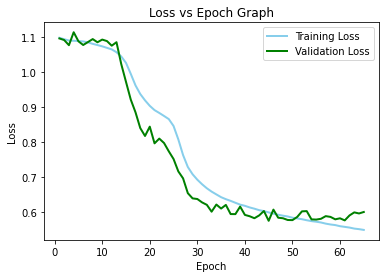

In [23]:
# multiple line plots
plt.plot(epoch_list, loss_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_loss_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Graph')
plt.legend(['Training Loss', 'Validation Loss'])

plt.savefig('../outputs/dilated_FI-2010 Loss Graph.png')
plt.show()

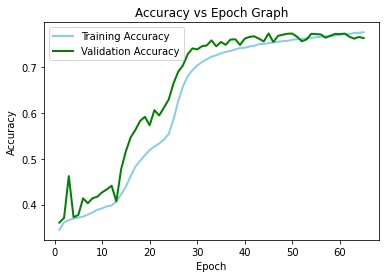

In [24]:
# multiple line plots
plt.plot(epoch_list, accuracy_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_accuracy_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.savefig('../outputs/dilated_FI-2010 Accuracy Graph.png')
plt.show()